# Train a neural network model to match the X to the Y

## Author
- Name: Stefanus Bernard Melkisedek
- Bangkit ID: m741d4ky3073
- Email: stefanussipahutar@gmail.com

# Introduction

In the previous **Bangkit ILT Tech Session**, I had the opportunity to attend a class on **Mastering Unsupervised Learning** and **ANN Basics: An Overview**. This class was led by the talented instructor, [Rahmat Fajri](https://github.com/rfajri27). 

During this session, we were given an interesting challenge: _Train a neural network model to match the X to the Y_. I was drawn by this challenge, and I would tackle it using the **TensorFlow** library.

The challenge revolves around training a neural network model to match the X (input) to the Y (output). Both X and Y are sequences of numbers. The goal is for the model to predict Y given X. The model is trained using training data and evaluated with validation data. Ultimately, the model should be able to generalize well to the test data.

In [1]:
# Import the necesary libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Defining the input array 'X'
X = np.array([-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0], dtype=float)

# Defining the output array 'Y'
Y = np.array([5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0], dtype=float)

## Prepared the Dataset

### Add extra dimension to the dataset

In [3]:
# Add an extra dimension to X and Y
X = np.expand_dims(X, axis=-1)
Y = np.expand_dims(Y, axis=-1)

<details>
    <summary><span style="color:green"><b>Click to see explanation</b></span></summary>

Neural networks in TensorFlow expect input data to be in a certain shape. Specifically, they expect each input to be a tensor (a multi-dimensional array) of a certain rank (number of dimensions).

When create a `tf.data.Dataset` using `from_tensor_slices`, each element of the dataset has the same shape as the slices passed in. If `X` and `Y` are 1D arrays, then each element of the dataset will be a scalar (a 0D tensor).

However, many neural networks expect each input to be at least a 1D tensor (an array of scalars), not a scalar itself. This is because each input often represents multiple features of a data point, and each feature is a separate element in the input tensor.

By using `np.expand_dims(X, axis=-1)`, this will add an extra dimension to `X`, turning it from a 1D array of scalars into a 2D array of 1D arrays. This means that each element of the resulting dataset will be a 1D array (a tensor of rank 1), which is the shape that the neural network expects for its inputs.

The same reasoning applies to `Y`. Even though `Y` represents the target values rather than the input data, it still needs to be in the shape that the neural network expects for its targets.

So, to summarize: Why do I add an extra dimension to `X` and `Y` ? It is to ensure that each element of the dataset is in the shape that the neural network expects. If I don't do this, the neural network will raise a `ValueError` when I try to train it.

</details>

### Creating a TensorFlow Dataset from Input and Target Arrays

In [4]:
# Create a tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((X, Y))

<details>
    <summary><span style="color:green"><b>Click to see explanation</b></span></summary>

When training a model in TensorFlow, the model's `fit` method expects the data to be in a certain format. Specifically, it expects a tuple of `(inputs, targets)`. 

If I just pass in the `X` array, the model wouldn't know what the corresponding target values are. It wouldn't know what it's supposed to be predicting. 

By creating a `tf.data.Dataset` using `from_tensor_slices`, I packaging the input data (`X`) and the target data (`Y`) together in the format that the model expects. Each element of the dataset is a tuple of `(input, target)`, so the model knows that for each input, there's a corresponding target that it should be predicting.

This is why I need to create a `tf.data.Dataset` from the `X` and `Y` arrays. It's all about getting the data into the format that the model expects.

</details>

## Define Custom Callback

In [5]:
class LossCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # If logs dictionary is None, initialize it as an empty dictionary
        if logs is None:
            logs = {}

        # If loss is less than a certain threshold, stop training
        if logs.get('loss') < 0.05:  
            print("\nReached 0.05 loss so cancelling training!")
            self.model.stop_training = True

## Build a Neural Network Model

### Create the Model

In [6]:
def create_uncompiled_model():
    """
    This function creates an uncompiled simple neural network model
    with two hidden layers and returns it.
    """

    # Defining a simple neural network model
    model = tf.keras.Sequential(
        [
            # Input layer with 1 input feature
            tf.keras.layers.InputLayer(shape=[1]),
            # First hidden layer with 16 neurons and ReLU activation function
            tf.keras.layers.Dense(units=16, activation="relu"),
            # Second hidden layer with 8 neurons and ReLU activation function
            tf.keras.layers.Dense(units=8, activation="relu"),
            # Output layer with 1 neuron
            tf.keras.layers.Dense(units=1),
        ]
    )

    # Returning the uncompiled model
    return model

In [7]:
# Create the Neural Network Model
model = create_uncompiled_model()

# Print the summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 177 (708.00 B)

 Trainable params: 177 (708.00 B)

 Non-trainable params: 0 (0.00 B)

## Tune Learning rate

In [8]:
# Get initial weights
init_weights = model.get_weights()

In [9]:
def adjust_learning_rate(training_dataset):
    """
    This function adjusts the learning rate for the model training process.
    It creates an uncompiled model, sets a learning rate schedule, compiles the model,
    and then fits the model to the provided dataset.

    Args:
        training_dataset: The dataset to be used for training the model.

    Returns:
        The history of the model training process.
    """

    # Create an uncompiled model
    model = create_uncompiled_model()

    # Define a learning rate schedule. The learning rate changes with each epoch.
    learning_rate_schedule = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: 1e-3 * 10 ** (epoch / 20)
    )

    # Select the Adam optimizer for the model
    adam_optimizer = tf.keras.optimizers.Adam()

    # Select the Huber loss for the model
    huber_loss = tf.keras.losses.Huber()

    # Select the Mean Squared Error as the metric for the model
    mse_metric = tf.keras.metrics.MeanSquaredError()

    # Compile the model with the Mean Squared Error loss, Adam optimizer, and accuracy as a metric
    model.compile(loss=huber_loss, optimizer=adam_optimizer, metrics=[mse_metric])

    # Fit the model to the dataset for 100 epochs, adjusting the learning rate according to the schedule
    training_history = model.fit(
        training_dataset, epochs=100, callbacks=[learning_rate_schedule]
    )

    return training_history

In [10]:
# Run the training with dynamic learning rate
learning_rate_history = adjust_learning_rate(dataset)

Epoch 1/100


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6.7891 - mean_squared_error: 59.0811 - learning_rate: 0.0010
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6654 - mean_squared_error: 57.3389 - learning_rate: 0.0011
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5386 - mean_squared_error: 55.5332 - learning_rate: 0.0013
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.3940 - mean_squared_error: 53.5150 - learning_rate: 0.0014
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2257 - mean_squared_error: 51.2397 - learning_rate: 0.0016
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0288 - mean_squared_error: 48.7302 - learning_rate: 0.0018
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7786 - mean_squared_error: 45.6454 - learning_rate: 0.0020
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4471 - mean_squared_error: 41.7070 - learning_rate: 0.0022
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

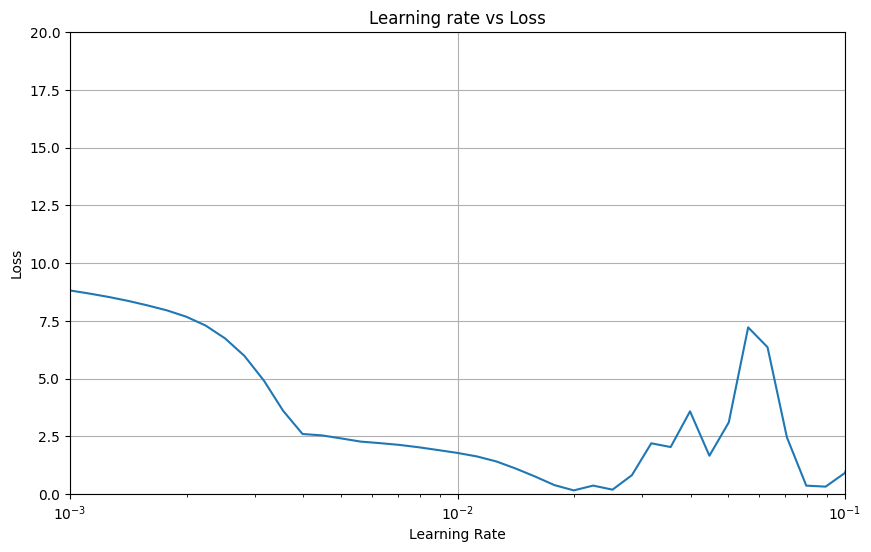

In [11]:
# Define variables for learning rate and loss
learning_rate = learning_rate_history.history["learning_rate"]
loss = learning_rate_history.history["loss"]

# Define axis limits
x_axis_limits = [1e-3, 1e-1]
y_axis_limits = [0, 20]

# Create a new figure with a specified size
plt.figure(figsize=(10, 6))

# Enable grid
plt.grid(True)

# Plot learning rate vs loss with a logarithmic scale on the x-axis
plt.semilogx(learning_rate, loss)

# Set the limits of the x and y axes
plt.axis(x_axis_limits + y_axis_limits)

# Set the title of the plot
plt.title('Learning rate vs Loss')

# Label the x and y axes
plt.xlabel('Learning Rate')
plt.ylabel('Loss')

# Display the plot
plt.show()

Based on the graph above, I would like to choose the learning rate of 3e-2 for training the model.

### Train the Model

In [12]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

<details>
<summary><span style="color:green"><b>Click to see explanation</span><b></summary>

This code is doing two things:

1. `tf.keras.backend.clear_session()`: This line is used to clear any leftover state from Keras. When you're running models, Keras keeps track of things like previously trained models, layers, and so on. This line clears all that out, so you're starting fresh.

2. `model.set_weights(init_weights)`: This line is resetting the weights of your model to their initial state. When you train a model, it changes its weights based on the input data. If you want to run the model again with the same initial weights (for example, to try training with different parameters), you can use this line to reset the weights back to their initial state.

</details>

In [20]:
# Set the learning rate
learning_rate = 3e-2

# Set the optimizer with the learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Set the loss function
loss = tf.keras.losses.Huber()

# Set the training parameters
model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=["mse"],
)

In [21]:
# Train the model
history = model.fit(dataset, epochs=100, callbacks=[LossCallback()])

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1643 - mse: 0.3293
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6034 - mse: 1.4849 
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5841 - mse: 4.5783 
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0666 - mse: 0.1333 
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2100 - mse: 0.4264 
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1347 - mse: 0.2695 
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5594 - mse: 1.2378 
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9205 - mse: 2.1279 
Epoch 9/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1040 - mse: 0.2080
Reached 0.05 loss so cancelling training!
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0434 - mse: 0.0867 


In [27]:
# Get the epoch at which training was stopped
stopped_epoch = len(history.history['loss'])

# Get the final loss and mse
final_loss = history.history['loss'][-1]
final_mse = history.history['mse'][-1]  # replace 'mse' with the name of your mse metric if it's different

print(f"Model stopped at epoch {stopped_epoch} with loss {final_loss:.4f} and mse {final_mse:.4f}")

Model stopped at epoch 9 with loss 0.0480 and mse 0.0960


## Predict the Output

In [23]:
def make_predictions(input_values, trained_model):
    """
    This function takes an array of input values and a trained model,
    reshapes the input for compatibility with the model,
    makes predictions, and rounds them to the nearest integer.
    
    Args:
        input_values (np.array): The input values for prediction
        trained_model (keras.Model): The pre-trained model to use for prediction

    Returns:
        np.array: The rounded predictions
    """
    # Reshape the input_values to ensure compatibility with the model
    reshaped_input = input_values.reshape(-1, 1)
    
    # Use the model to make predictions
    raw_predictions = trained_model.predict(reshaped_input)
    
    # Round the predictions to the nearest integer
    rounded_predictions = raw_predictions.round()
    
    return rounded_predictions

In [24]:
# Define the input data
input_data = np.array([4, 5])

# Use the function to make predictions
predictions = make_predictions(input_data, model)

# Print the predictions
for i, prediction in enumerate(predictions):
    print(f"Prediction for input {input_data[i]}: {prediction[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Prediction for input 4: 13.0
Prediction for input 5: 14.0


## Conclusion

As we can see, the model above is able to predict the output precisely based on the input. The proof of what I mean **precisely** is that the model is able to predict the output with a very small error rate. 

The input and output from the X and Y are as follows:

- X = [-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]

- Y = [5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0]

When the machine learning model takes the input X = 4 and predicts the output Y, the model predicts the output Y = 13.0. This is the correct output, as the actual output is 13.0.

Below I will show the linear algebra equations that represent the relationship between X and Y and linear regression plot of the data points X and Y.

### Linear Algebra Equations

In [25]:
# Defining the data points
X = np.array([-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0], dtype=float)
Y = np.array([5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0], dtype=float)

# Perform linear regression to find the slope and intercept of the best fit line
slope, intercept = np.polyfit(X, Y, 1)

# Print the slope and intercept
print(f"Slope: {slope:.4f}, Intercept: {intercept:.4f}")

Slope: 1.0000, Intercept: 9.0000


The linear equation derived from the slope and intercept is:

$$ y = mx + c $$

where:
- $m$ is the slope
- $c$ is the intercept

Now, since the slope and intercept are known, we can substitute the values into the equation:

$$ y = 1.0x + 9.0 $$

### Linear Regression Plot

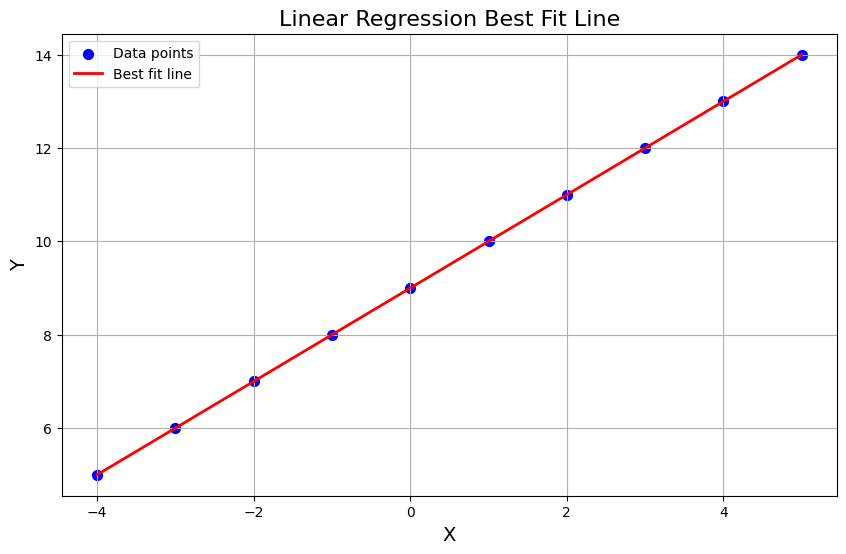

In [26]:
# Generate y-values for the best fit line
best_fit_Y = slope * X + intercept

# Define the size of the figure
plt.figure(figsize=(10, 6))

# Plot the original data points
plt.scatter(X, Y, color='blue', s=50, label='Data points')

# Plot the best fit line
plt.plot(X, best_fit_Y, color='red', linewidth=2, label='Best fit line')

# Add a title
plt.title('Linear Regression Best Fit Line', fontsize=16)

# Add x and y labels
plt.xlabel('X', fontsize=14)
plt.ylabel('Y', fontsize=14)

# Add a legend
plt.legend()

# Add grid lines
plt.grid(True)

# Show the plot
plt.show()

## Closing Remarks

Overall, This challenge was a great learning experience for me. I learned how to train a neural network model to match the X to the Y. I also learned how to create a TensorFlow dataset from input and target arrays, define a custom callback, build a neural network model, tune the learning rate, train the model, and predict the output. I'm excited to apply these skills to future projects.

I would like to thank Insturctor [Rahmat Fajri](https://github.com/rfajri27) for leading the session and providing the challenge. I would also like to thank the Bangkit team for organizing the session. I look forward to attending more sessions in the future.